In [ ]:
#SRCNN(no pooling layers-downscaling or dimensionality reduction)
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import numpy as np

# --- Define PSNR metric ---
def psnr_metric(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

# --- Build SRCNN model for color images ---
def build_srcnn(input_shape=(33, 33, 3)):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, 9, activation='relu', padding='same')(inputs)
    x = layers.Conv2D(32, (1, 1), activation='relu', padding='same')(x)
    outputs = layers.Conv2D(3, (5, 5), activation='linear', padding='same')(x)
    model = models.Model(inputs, outputs)
    return model

# --- Create and compile model ---
srcnn = build_srcnn((33, 33, 3))
srcnn.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
              loss='mse',
              metrics=[psnr_metric])

srcnn.summary()

# --- Dummy data for demo (replace with your training data) ---
x_train = np.random.rand(100, 33, 33, 3).astype(np.float32)
y_train = np.random.rand(100, 33, 33, 3).astype(np.float32)

# --- Train ---
srcnn.fit(x_train, y_train, epochs=2, batch_size=8)
# --- Save trained model ---
srcnn.save("srcnn_color.h5")


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 33, 33, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_95 (Conv2D)              │ (None, 33, 33, 64)     │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_96 (Conv2D)              │ (None, 33, 33, 32)     │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_97 (Conv2D)              │ (None, 33, 33, 3)      │         2,403 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,099 (78.51 KB)

 Trainable params: 20,099 (78.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.2680 - psnr_metric: 5.8058
Epoch 2/2
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.1289 - psnr_metric: 8.9062


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step


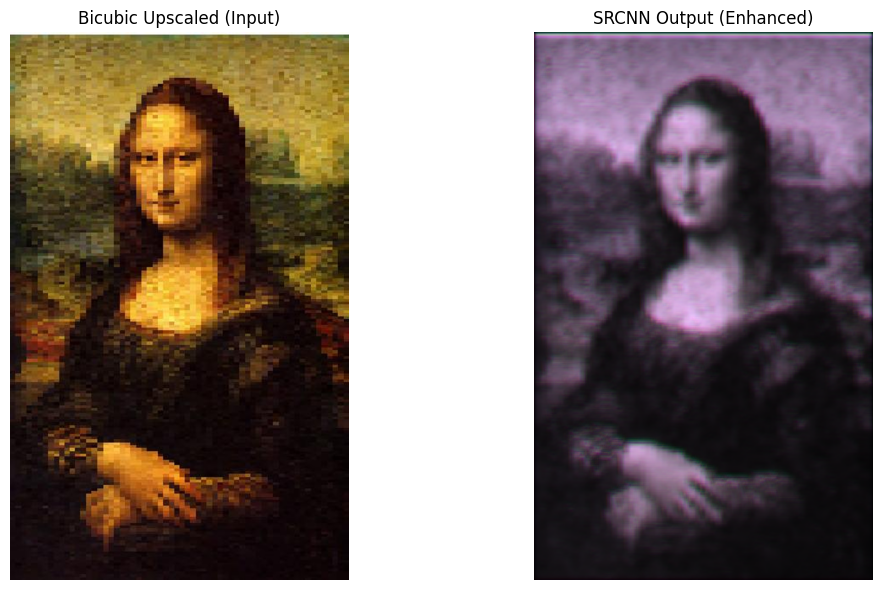

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models

# --- Define SRCNN model ---
def build_srcnn(input_shape=(None, None, 3)):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, (9, 9), activation='relu', padding='same')(inputs)
    x = layers.Conv2D(32, (1, 1), activation='relu', padding='same')(x)
    outputs = layers.Conv2D(3, (5, 5), activation='linear', padding='same')(x)
    model = models.Model(inputs, outputs)
    return model

# --- Load trained model ---
model = build_srcnn()
model.load_weights("/content/srcnn_color.h5")  # or the path where you saved it

# --- Load and preprocess image ---
img = cv2.imread("/content/Monalisa.jpg")
if img is None:
    raise FileNotFoundError("Image not found!")

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Create bicubic upscaled version for comparison
upscaled = cv2.resize(img, (img.shape[1]*2, img.shape[0]*2), interpolation=cv2.INTER_CUBIC)


# Normalize and prepare for model
input_img = img.astype(np.float32) / 255.0
input_img = np.expand_dims(input_img, axis=0)

# --- Predict super-resolution image ---
pred = model.predict(input_img)[0]
pred = np.clip(pred, 0, 1)
output = (pred * 255).astype(np.uint8)

# --- Display Input vs Output ---
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(upscaled)
plt.title("Bicubic Upscaled (Input)")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(output)
plt.title("SRCNN Output (Enhanced)")
plt.axis("off")

plt.tight_layout()
plt.show()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 77s 77s/step


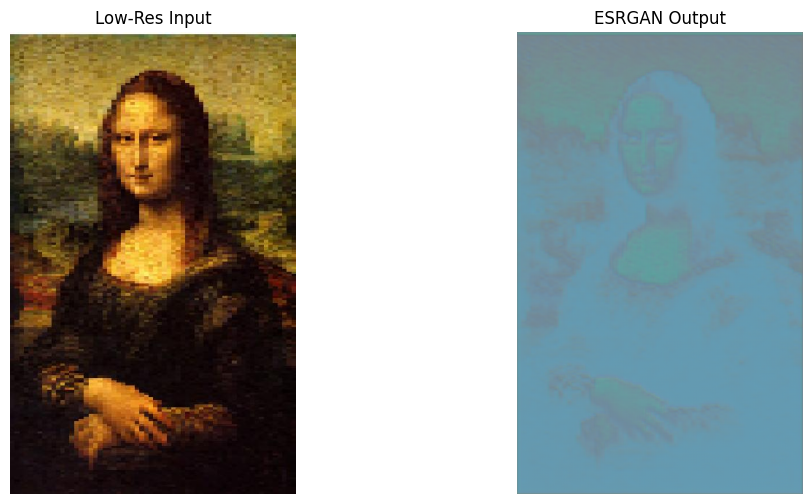

True

In [ ]:
#ESRGAN
import tensorflow as tf
from tensorflow.keras import layers, models
import cv2
import numpy as np
import matplotlib.pyplot as plt

# --- RRDB Block ---
def dense_block(x, filters, growth=32):
    concat_feat = [x]
    for i in range(5):
        out = layers.Conv2D(growth, 3, padding='same', activation='relu')(x)
        concat_feat.append(out)
        x = layers.Concatenate()(concat_feat)
    out = layers.Conv2D(filters, 3, padding='same')(x)
    return layers.Add()([out, concat_feat[0]])

def rrdb_block(x, filters):
    out = dense_block(x, filters)
    out = dense_block(out, filters)
    out = dense_block(out, filters)
    return layers.Add()([x, out * 0.2])



def build_esrgan_generator(num_rrdb=5, filters=64, input_shape=(None, None, 3)):
    inputs = layers.Input(shape=input_shape)
    fea = layers.Conv2D(filters, 3, padding='same')(inputs)

    x = fea
    for _ in range(num_rrdb):
        x = rrdb_block(x, filters)

    x = layers.Conv2D(filters, 3, padding='same')(x)
    x = layers.Add()([fea, x])

    # Upsample 2x twice → total 4x
    for _ in range(2):
        x = layers.Conv2D(filters * 4, 3, padding='same')(x)
        x = layers.Lambda(lambda x: tf.nn.depth_to_space(x, 2))(x)
        x = layers.LeakyReLU(alpha=0.2)(x)

    outputs = layers.Conv2D(3, 3, padding='same', activation='tanh')(x)
    return models.Model(inputs, outputs)

# Build generator
generator = build_esrgan_generator()



# Load low-resolution image
img = cv2.imread("/content/Monalisa.jpg")
if img is None:
    raise FileNotFoundError("Image not found!")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Normalize to [-1, 1] as ESRGAN expects
input_img = img.astype(np.float32)
input_img = input_img / 127.5 - 1.0
input_img = np.expand_dims(input_img, axis=0)  # add batch dimension


sr_img = generator.predict(input_img)[0]
sr_img = (sr_img + 1.0) * 127.5  # denormalize back to [0, 255]
sr_img = np.clip(sr_img, 0, 255).astype(np.uint8)



plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Low-Res Input")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(sr_img)
plt.title("ESRGAN Output")
plt.axis("off")

plt.show()

# Optionally save
cv2.imwrite("output_esrgan.png", cv2.cvtColor(sr_img, cv2.COLOR_RGB2BGR))